In [2]:
import numpy as np
import pandas as pd
import emcee

In [5]:
DF = pd.read_table('../grid/SG_US_step.dat', sep='\t')

In [6]:
DF.head()

,id,M,Y,Z,alpha,diffusion,settling,eta,overshoot,undershoot,...,r13_58,r13_59,r10_57,r10_58,r02_61,r01_59,r01_60,r13_60,r10_59,r02_60
0,20000,0.75408,0.258478,0.000279,2.220276,0.009972,0.009972,0,0.35059,0.083513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000,0.75408,0.258478,0.000279,2.220276,0.009972,0.009972,0,0.35059,0.083513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000,0.75408,0.258478,0.000279,2.220276,0.009972,0.009972,0,0.35059,0.083513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20000,0.75408,0.258478,0.000279,2.220276,0.009972,0.009972,0,0.35059,0.083513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20000,0.75408,0.258478,0.000279,2.220276,0.009972,0.009972,0,0.35059,0.083513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
DF = DF[np.logical_or.reduce((
    DF['diffusion'] > 0.8,
    DF['diffusion'] < 1.2,
    DF['settling'] > 0.8,
    DF['settling'] < 1.2,
    DF['overshoot'] < 0.2,
    DF['undershoot'] < 0.2))]

In [70]:
DF = DF.drop(DF.index[np.isnan(DF['dnu02'])])

In [7]:
KIC = pd.read_table('../regression/perturb/final/7970740_perturb.dat')

In [27]:
KIC.head()

,Teff,Fe/H,nu_max,Dnu0,dnu02,r02,r01,r10
0,5309.000000,-0.540000,4197.000000,173.379034,8.536836,0.049290,0.014690,0.014803
1,5406.247480,-0.572623,4259.500565,173.461297,8.348929,0.048154,0.014845,0.014886
2,5291.495691,-0.513386,4179.294972,173.189313,8.578192,0.049516,0.014402,0.014621
3,5326.634508,-0.440346,4233.747382,173.299814,8.426018,0.048641,0.014673,0.014663
4,5274.490584,-0.492826,4141.516938,173.399443,8.282791,0.047827,0.014722,0.015179


In [41]:
Teff = KIC['Teff'][0]
dTeff = np.std(KIC['Teff'])

FeH = KIC['Fe/H'][0]
dFeH = np.std(KIC['Fe/H'])

nu_max = KIC['nu_max'][0]
dnu_max = np.std(KIC['nu_max'])

Dnu0 = KIC['Dnu0'][0]
dDnu0 = KIC['Dnu0'][0]

dnu02 = KIC['dnu02'][0]
ddnu02 = np.std(KIC['dnu02'])

In [91]:
min_Y = np.min(DF['Y'])
max_Y = np.max(DF['Y'])

min_Z = np.min(DF['Z'])
max_Z = np.max(DF['Z'])

min_a = np.min(DF['alpha'])
max_a = np.max(DF['alpha'])

def lnprior(theta):
    M, Y, Z, alpha, age = theta
    if 0.7 < M < 0.9 and min_Y < Y < max_Y and \
            min_Z < Z < max_Z and min_a < alpha < max_a and \
            8 < age < 13:
        return 0.0
    return -np.inf

def lnlike(theta):
    M, Y, Z, alpha, age = theta
    idx = (np.abs(DF['M']-M) + \
           np.abs(DF['Y']-Y) + \
           np.abs(DF['Z']-Z) + \
           np.abs(DF['alpha']-alpha) + \
           np.abs(DF['age']-age)).values.argmin()
    row = DF.iloc[idx]
    chi2 = (row['Teff']   -   Teff)**2 / dTeff   + \
           (row['Fe_H']   -    FeH)**2 / dFeH    + \
           (row['nu_max'] - nu_max)**2 / dnu_max + \
           (row['Dnu0']   -   Dnu0)**2 / dDnu0   + \
           (row['dnu02']  -  dnu02)**2 / ddnu02
    return(-chi2/2)

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [93]:
lnprob([0.75408, 0.258478, 0.000279, 2.220276, 9])
#lnprob([7.21748641e-01, 2.47988905e-01, 3.90556787e-03, 1.54462387e+00,
#  1.07337299e+01])
#lnprob([0.82510679, 0.23599072, 0.01876741, 1.52110795,10.73980817])

#M, Y, Z, alpha, age = [7.21748641e-01, 2.47988905e-01, 3.90556787e-03, 1.54462387e+00,
# 1.07337299e+01]
#idx = (np.abs(DF['M']-M) + \
#           np.abs(DF['Y']-Y) + \
#           np.abs(DF['Z']-Z) + \
#           np.abs(DF['alpha']-alpha) + \
#           np.abs(DF['age']-age)).values.argmin()
#print(idx)

#print(DF.shape)

#row = DF.iloc[idx]
#row

-14768.421605072388

In [94]:
ndim, nwalkers = 5, 100
pos = [[7.601373789062498831e-01, 
        2.480115351562501291e-01, 
        7.114554687500006941e-03, 
        1.557601917968750138e+00,
        1.070942461134874435e+01] + 1e-4*np.random.randn(ndim) 
    for i in range(nwalkers)]

In [95]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, 500)

(array([[7.13090434e-01, 2.66569250e-01, 1.43809643e-02, 1.37375424e+00,
         1.07025513e+01],
        [7.11343815e-01, 2.33124751e-01, 3.15593137e-02, 1.38310917e+00,
         1.06742072e+01],
        [8.36411909e-01, 2.78383652e-01, 2.64391857e-02, 1.56469230e+00,
         1.07279507e+01],
        [7.19065176e-01, 2.55899131e-01, 8.56046024e-03, 1.39378670e+00,
         1.07092428e+01],
        [7.29060450e-01, 2.26846355e-01, 1.43732221e-02, 1.58331367e+00,
         1.06264320e+01],
        [7.48392728e-01, 3.20868179e-01, 3.86751454e-02, 1.51110822e+00,
         1.07291327e+01],
        [8.92390236e-01, 2.43017880e-01, 3.03166153e-02, 1.72783563e+00,
         1.07718002e+01],
        [7.01807776e-01, 2.36327028e-01, 1.31985288e-02, 1.41302581e+00,
         1.07107101e+01],
        [7.02166975e-01, 2.33383770e-01, 8.05570317e-03, 1.78034166e+00,
         1.09293734e+01],
        [7.08311921e-01, 2.21620966e-01, 2.67323905e-02, 1.34497127e+00,
         1.06457416e+01],
        [7

In [96]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/scratch/seismo/bellinger/python/anaconda3-5.3.0/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


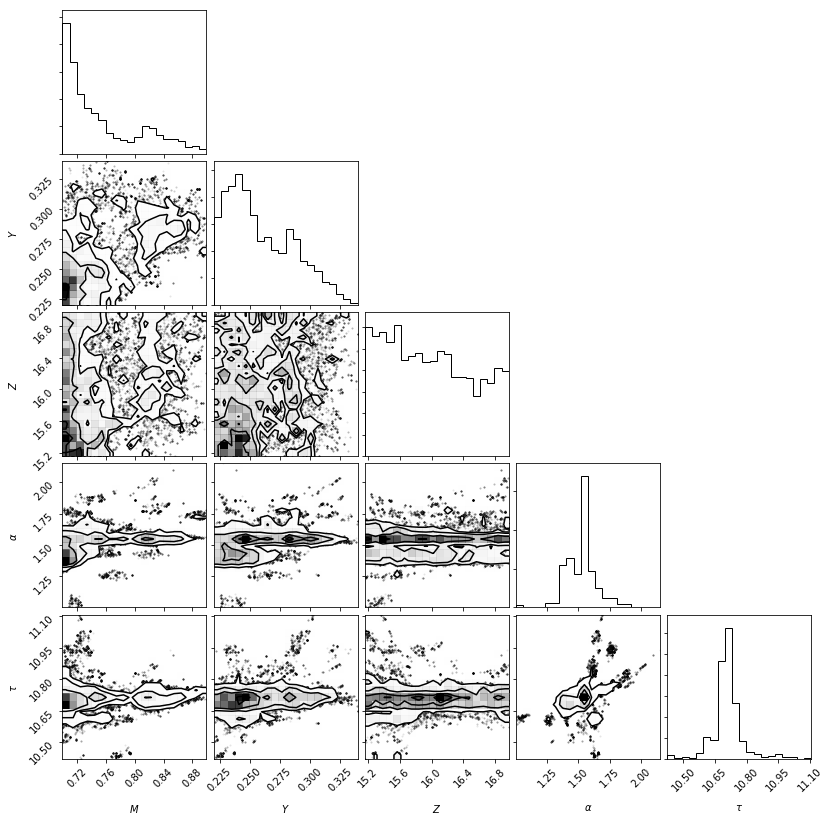

In [102]:
%matplotlib inline
import matplotlib

import corner
fig = corner.corner(samples, labels=["$M$", "$Y$", "$Z$", r'$\alpha$', r'$\tau$'])
fig.show()

In [100]:
samples[:, 2] = np.exp(samples[:, 2])
list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0))))

[(0.7353777174870217, 0.08727497613487079, 0.028190558237808805),
 (0.25256167815958314, 0.03790968875300155, 0.020948051206412382),
 (15.927722501473882, 0.6985082455182816, 0.5451560921399459),
 (1.5400317429711747, 0.07847929804297316, 0.13531837910972477),
 (10.705466649181519, 0.045037658095202104, 0.03752895535996714)]